<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

---
    Mubina | Wei Hua | Liubin    

# Part 3: Feature Engineering, Data Preprocessing, and Modelling

For this notebook, we will train and several classification models to predict the presence of WNV. 

Our methodology is as follows. We will compare the following 3 datasets, to see the effect that weather conditions may have on our predictions.
1. Dataset with no weather features
2. Dataset with weather features for the current day, based on the nearest weather station
3. Dataset with moving average and time lagged weather features, based on the nearest weather station

For each of these data sets, we will train the data on a logistic regression, KNN classifier, and random forest classifier.We will use the ROC AUC, and the recall score as metrics to compare the performance of our models.

### Contents:
> 1. [Feature Engineering](#1.-Feature-Engineering)
> 2. [Data Preprocessing](#2.-Data-Preprocessing)
> 3. [Data Modelling](#3.-Data-Modelling)
> 4. [Kaggle Submissions](#4.-Kaggle-Submission)
> 5. [Feature Interpretation](#5.-Feature-Interpretation)

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import geopy.distance


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, auc, roc_curve, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [49]:
#import data 
train = pd.read_csv('../assets/train_cleaned.csv')
weather= pd.read_csv('../assets/weather_cleaned.csv', index_col='index' )
spray = pd.read_csv('../assets/spray_cleaned.csv')
test = pd.read_csv('../assets/test_cleaned.csv')

## 1. Feature Engineering

### 1.1. Weather Data

- For the weather data, there are 3 weather related factors that have an impact on mosquito activity: [see here for more info](https://www.mosquitosquad.com/central-illinois/about-us/blog/2018/july/how-does-weather-affect-mosquito-activity-/)
>1. Rainfall
>2. Humidity
>3. Cooler Temperatures

- As temperature is already a feature, lets try to create features related to rain and humidity 
- We will create a new dataframe with moving averages and time lagged data, which we can use for modeling.

In [50]:
weather.head()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day
index,,,,,,,,,,,,,,,,,,,,,
0,1,2007-05-01,83,50,67,51,56,0,2,0448,...,,0.00,29.10,29.82,1.7,27,9.2,2007,5,1
1,2,2007-05-01,84,52,68,51,57,0,3,-,...,,0.00,29.18,29.82,2.7,25,9.6,2007,5,1
2,1,2007-05-02,59,42,51,42,47,14,0,0447,...,BR,0.00,29.38,30.09,13.0,4,13.4,2007,5,2
3,2,2007-05-02,60,43,52,42,47,13,0,-,...,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2007,5,2
4,1,2007-05-03,66,46,56,40,48,9,0,0446,...,,0.00,29.39,30.12,11.7,7,11.9,2007,5,3


In [51]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2918 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   station      2918 non-null   int64  
 1   date         2918 non-null   object 
 2   tmax         2918 non-null   int64  
 3   tmin         2918 non-null   int64  
 4   tavg         2918 non-null   int64  
 5   dewpoint     2918 non-null   int64  
 6   wetbulb      2918 non-null   int64  
 7   heat         2918 non-null   int64  
 8   cool         2918 non-null   int64  
 9   sunrise      2918 non-null   object 
 10  sunset       2918 non-null   object 
 11  codesum      2918 non-null   object 
 12  preciptotal  2918 non-null   object 
 13  stnpressure  2918 non-null   float64
 14  sealevel     2918 non-null   float64
 15  resultspeed  2918 non-null   float64
 16  resultdir    2918 non-null   int64  
 17  avgspeed     2918 non-null   float64
 18  year         2918 non-null   int64  
 19  month 

In [52]:
# convert date to datetime type
weather['date'] = pd.to_datetime(weather['date'])

In [53]:
# drop year, month, and day features (will calculate these features on the train/test datasets instead)
weather.drop(['year','month','day'], axis = 1, inplace = True)

In [54]:
# replace missing values and convert to float
col_exclude = ['date', 'codesum', 'station']
for i in weather.columns: 
    if i not in col_exclude: 
        weather[i].replace('M', 0, inplace=True) #'M' means missing
        weather[i].replace('-', 0, inplace=True) #'-' is 0
        weather[i].replace('  T', 0.005, inplace=True) #'T' is trace (greater than zero but very small)
        weather[i] = weather[i].astype('float') #convert to float


In [55]:
weather.codesum.value_counts()

                 1596
RA                292
RA BR             236
BR                108
TSRA RA BR         92
                 ... 
TS TSRA RA HZ       1
RA DZ SN            1
FU                  1
TS TSRA HZ          1
FG+ FG BR           1
Name: codesum, Length: 97, dtype: int64

- RA is the code for rain. However, there are many values missing for codesum

In [56]:
weather.preciptotal.describe()

count    2918.000000
mean        0.132425
std         0.394498
min         0.000000
25%         0.000000
50%         0.000000
75%         0.060000
max         6.860000
Name: preciptotal, dtype: float64

In [57]:
weather[weather.codesum.str.contains('RA')]['preciptotal'].describe()

count    1025.000000
mean        0.358288
std         0.597591
min         0.000000
25%         0.030000
50%         0.140000
75%         0.450000
max         6.860000
Name: preciptotal, dtype: float64

- I will classify the following for rain:
> 1. light rain: preciptotal > 0 and less than 10th percentile for codesum "RA"
> 2. moderate rain: preciptotal > 10th percentile and < 50th percentile for codesum "RA"
> 3. heavy rain: preciptotal > 50th percentile for codesum "RA"

In [58]:
# create rain features
light_rain_max = weather[weather.codesum.str.contains('RA')]['preciptotal'].quantile(0.1)
heavy_rain_min = weather[weather.codesum.str.contains('RA')]['preciptotal'].quantile(0.5)

weather['light_rain'] = ((weather['preciptotal'] > 0) & (weather['preciptotal'] <= light_rain_max)).astype(int)
weather['moderate_rain'] = ((weather['preciptotal'] > light_rain_max) & (weather['preciptotal'] <= heavy_rain_min)).astype(int)
weather['heavy_rain'] = (weather['preciptotal'] > heavy_rain_min).astype(int)

In [59]:
# drop codesum
weather.drop('codesum', axis = 1, inplace = True)

In [60]:
# calculate relative humidity from temperature and dew point

def rel_humidity(Tavg, dewpoint):
    # convert to celsius
    T_cel = (Tavg-32)/1.8
    Tdp_cel = (dewpoint-32)/1.8
    
    #calculate relative humidity
    RH = 100*np.exp((17.625*Tdp_cel)/(243.04+Tdp_cel))/np.exp((17.625*T_cel)/(243.04+T_cel))
    return RH

weather["rel_humidity"] = rel_humidity(weather['tavg'],weather['dewpoint'])

In [61]:
# calculate day length
weather['day_length'] = weather['sunset'] - weather['sunrise']

- Lets ensure there is data for every date/station comibination in the dataframe. If there is no data for a station on a particular date, we will use the data from other station for that date only.

In [62]:
station_1 = weather[weather['station'] == 1]
station_2 = weather[weather['station']==2]

dates = weather['date'].values

station_1_missing = list(set(dates) - set(station_1['date'].values))
station_2_missing = list(set(dates) - set(station_2['date'].values))

In [63]:
# check dates station 1 is missing
station_1_missing

[numpy.datetime64('2009-06-18T00:00:00.000000000'),
 numpy.datetime64('2011-09-08T00:00:00.000000000'),
 numpy.datetime64('2009-06-26T00:00:00.000000000'),
 numpy.datetime64('2009-09-07T00:00:00.000000000'),
 numpy.datetime64('2013-08-11T00:00:00.000000000'),
 numpy.datetime64('2011-09-20T00:00:00.000000000'),
 numpy.datetime64('2007-06-29T00:00:00.000000000'),
 numpy.datetime64('2012-09-03T00:00:00.000000000')]

In [64]:
# check dates station 2 is missing
station_2_missing

[numpy.datetime64('2007-05-04T00:00:00.000000000'),
 numpy.datetime64('2007-06-13T00:00:00.000000000'),
 numpy.datetime64('2014-08-26T00:00:00.000000000'),
 numpy.datetime64('2014-07-23T00:00:00.000000000'),
 numpy.datetime64('2013-10-06T00:00:00.000000000'),
 numpy.datetime64('2013-05-02T00:00:00.000000000'),
 numpy.datetime64('2007-06-28T00:00:00.000000000'),
 numpy.datetime64('2013-09-29T00:00:00.000000000'),
 numpy.datetime64('2012-08-22T00:00:00.000000000'),
 numpy.datetime64('2008-07-08T00:00:00.000000000'),
 numpy.datetime64('2011-09-14T00:00:00.000000000'),
 numpy.datetime64('2013-09-24T00:00:00.000000000'),
 numpy.datetime64('2014-05-02T00:00:00.000000000'),
 numpy.datetime64('2008-10-01T00:00:00.000000000'),
 numpy.datetime64('2011-07-22T00:00:00.000000000'),
 numpy.datetime64('2013-08-12T00:00:00.000000000')]

In [65]:
# For dates with missing station data,use the data from the other station

for i in range(len(station_1_missing)):
    station_1 = station_1.append(station_2[station_2['date']==station_1_missing[i]])
    station_1['station'] = 1
    
    
for i in range(len(station_2_missing)):
    station_2 = station_2.append(station_1[station_1['date']==station_2_missing[i]])
    station_2['station'] = 2
    
weather = pd.concat([station_1, station_2])

In [66]:
# duplicate the weather dataframe to create a dataset that includes moving average and timelagged data

weather_lags = weather.copy()

In [67]:
# compute rolling averages
weather_cols = [cols for cols in weather_lags.columns if weather_lags[cols].dtype in [float, int]]

for i in [3,7,10, 14,21]: # 3 day, 7 day, 10 day, 14 day, 21 day rolling average 
    for j in weather_cols:
        weather_lags[j + '_rolling_' + str(i)] = weather_lags[j].rolling(window=i).mean()          

weather_lags.tail()

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,stnpressure_rolling_21,sealevel_rolling_21,resultspeed_rolling_21,resultdir_rolling_21,avgspeed_rolling_21,light_rain_rolling_21,moderate_rain_rolling_21,heavy_rain_rolling_21,rel_humidity_rolling_21,day_length_rolling_21
index,,,,,,,,,,,,,,,,,,,,,
2500,2,2013-09-24,70.0,49.0,60.0,49.0,54.0,5.0,0.0,541.0,...,29.314286,30.010952,9.028571,19.904762,10.147619,0.142857,0.380952,0.047619,60.598509,777.523810
2578,2,2014-05-02,53.0,46.0,50.0,39.0,45.0,15.0,0.0,447.0,...,29.293810,29.992381,9.138095,20.142857,10.295238,0.142857,0.380952,0.047619,60.586899,844.333333
674,2,2008-10-01,61.0,46.0,54.0,40.0,47.0,11.0,0.0,548.0,...,29.290476,29.990952,9.438095,20.666667,10.547619,0.142857,0.380952,0.047619,60.432372,900.809524
1636,2,2011-07-22,88.0,70.0,79.0,70.0,73.0,0.0,14.0,435.0,...,29.286190,29.989048,9.057143,19.761905,10.480952,0.142857,0.380952,0.095238,61.912332,971.571429
2414,2,2013-08-12,82.0,67.0,75.0,65.0,68.0,0.0,10.0,456.0,...,29.282857,29.988095,9.147619,20.523810,10.580952,0.142857,0.380952,0.142857,63.242544,1038.333333


In [68]:
# compute shifted features

for i in [1,3,7,14,21]:
    for j in weather_cols:
        weather_lags[j + '_shift_' + str(i)] = weather_lags[j].shift(periods=i)

### 1.2 Train and Test data

- For the train and test data, we will create additional features related to the date (such as the day of the year, day of the week, month, etc)
- We will also add a feature for the nearest weather station (based on the latitude and longitude features), so we can merge the weather data more easily

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    8475 non-null   object 
 1   address                 8475 non-null   object 
 2   species                 8475 non-null   object 
 3   block                   8475 non-null   int64  
 4   street                  8475 non-null   object 
 5   trap                    8475 non-null   object 
 6   addressnumberandstreet  8475 non-null   object 
 7   latitude                8475 non-null   float64
 8   longitude               8475 non-null   float64
 9   addressaccuracy         8475 non-null   int64  
 10  nummosquitos            8475 non-null   int64  
 11  wnvpresent              8475 non-null   int64  
 12  year                    8475 non-null   int64  
 13  month                   8475 non-null   int64  
 14  day                     8475 non-null   

In [70]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      116293 non-null  int64  
 1   date                    116293 non-null  object 
 2   address                 116293 non-null  object 
 3   species                 116293 non-null  object 
 4   block                   116293 non-null  int64  
 5   street                  116293 non-null  object 
 6   trap                    116293 non-null  object 
 7   addressnumberandstreet  116293 non-null  object 
 8   latitude                116293 non-null  float64
 9   longitude               116293 non-null  float64
 10  addressaccuracy         116293 non-null  int64  
 11  year                    116293 non-null  int64  
 12  month                   116293 non-null  int64  
 13  day                     116293 non-null  int64  
 14  nearest_station     

In [71]:
# set id as index
test.set_index('id',inplace=True)

In [72]:
# convert date to datetime type
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [73]:
# create additional date features
def date_feat(df):
    df['day_of_year'] = df['date'].dt.dayofyear 
    df['half_month'] = df['date'].dt.month + df['date'].map(lambda x: .5 if x.day > 15 else 0)  
    df['week'] = df['date'].dt.isocalendar().week
    return df

train = date_feat(train)
test = date_feat(test)

In [74]:
# create a feature for the number of days since the day with the peak number of WnvPresent

max_day = train.groupby(by='day_of_year')['wnvpresent'].sum().sort_values(ascending= False).index[0]
test['days_since_max_wnv'] = abs(max_day-test['day_of_year'])
train['days_since_max_wnv'] = abs(max_day-train['day_of_year'])

In [75]:
max_day

227

In [58]:
train.shape

(8475, 20)

In [60]:
test.shape

(116293, 18)

## 2. Data Preprocessing

In [63]:
# drop features not used for modeling
train.drop(['address','addressnumberandstreet', 'nummosquitos'], axis=1, inplace=True)
test.drop(['address','addressnumberandstreet'], axis=1, inplace=True)

In [64]:
# create dummy features for categorical data

dummy_col = ['species','block','street','trap','month','half_month','week']

df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
df = pd.get_dummies(df, prefix=dummy_col, columns=dummy_col)

test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]

In [65]:
# drop ind column
test=test.copy()
train=train.copy()
test.drop(['ind', 'wnvpresent'],axis = 1, inplace = True)
train.drop('ind',axis = 1, inplace = True)

In [66]:
train.shape

(8475, 407)

In [67]:
test.shape

(116293, 406)

- Export the 3 datasets used for modeling. This way we do not need to run the code above again.

In [68]:
# no weather dataset
train.to_csv('../models/train_baseline.csv', index = False)
test.to_csv('../models/test_baseline.csv', index = False)

In [69]:
# current day weather dataset

def combine_weather(df, weather):
    df = df.join(weather.set_index(['date','station']), on=(['date','nearest_station']), how='left') 
    df.drop(['nearest_station'], axis=1, inplace=True) 
    return df

train_weather = combine_weather(train, weather)
train_weather.to_csv('../models/train_weather.csv', index = False)
test_weather = combine_weather(test, weather)
test_weather.to_csv('../models/test_weather.csv', index = False)

In [70]:
# moving average + time lagged weather dataset

train_wlag = combine_weather(train, weather_lags)
train_wlag.to_csv('../models/train_wlag.csv', index = False)
test_wlag = combine_weather(test, weather_lags)
test_wlag.to_csv('../models/test_wlag.csv', index = False)

In [31]:
# import dataframes

train_base = pd.read_csv('../models/model_datasets/train_baseline.csv')
train_w = pd.read_csv('../models/model_datasets/train_weather.csv')
train_wlag = pd.read_csv('../models/model_datasets/train_wlag.csv')

datasets = {'baseline':train_base,
            'current_weather':train_w,
            'MA_shifted_weather':train_wlag}

In [12]:
# define functions for modeling

# compare recall scores
def display_recall(model, X_train, y_train, X_test, y_test):
    print('Train Recall: ', round(recall_score(y_train, model.predict(X_train)),5))
    print('Test Recall: ', round(recall_score(y_test, model.predict(X_test)),5))
    print('Cross Val Recall:', round(cross_val_score(model, X_test,y_test, scoring = 'recall').mean(),5))
    
# plot ROC and Confusion matrix
def plot_model(model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot ROC curve
    ax1.set_title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax = ax1)
    ax1.plot([0, 1], [0, 1],label='baseline', linestyle='--')
    ax1.legend()

    #Plot confusion matrix
    ax2.set_title('Confusion Matrix')
    y_labeled = y_test.map({1:'WNV Present', 0:'WNV Not Present'})
    y_pred = pd.Series(model.predict(X_test)).map({1:'WNV Present', 0:'WNV Not Present'})
    cm = confusion_matrix(y_labeled, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.xaxis.set_ticklabels(['WNV Not Present', 'WNV Present']) 
    ax2.yaxis.set_ticklabels(['WNV Not Present', 'WNV Present'])
    plt.show();

# model comparisons
model_dictionary = {}
def add_model(name, model, X_test, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    model_dictionary[name] = [round(recall_score(y_test, model.predict(X_test)),5), #Recall 
                              round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),5), #ROC AUC 
                              tp, #True Positive
                              fp, #False Positive
                              tn, #True Negative
                              fn #False Negative
                             ]
    return model_dictionary

In [13]:
# function to run all 3 datasets through one model
def run_datasets(name,gs_model):
    
    data = datasets.copy()
    for jj in datasets:
        data[jj] = datasets[jj].drop('date', axis = 1)
        Xtrain,Xtest,ytrain,ytest=train_test_split(data[jj].drop('wnvpresent',1),data[jj]['wnvpresent'],test_size=0.2,random_state=42,stratify=data[jj]['wnvpresent'])
        print(jj)
        print('Xtrain',Xtrain.shape)
        print('Xtest',Xtest.shape)
        
        #scale
        ss = StandardScaler()
        Xs_train = ss.fit_transform(Xtrain)
        Xs_test = ss.transform(Xtest)
        
        #smote
        smt=SMOTE(random_state=42)
        Xsm_train,ysm_train=smt.fit_resample(Xs_train,ytrain)
        
        #fit model
        gs_model.fit(Xs_train,ytrain)
        best_model = gs_model.best_estimator_
        
        #print best parameters
        print('best parameters: ' ,gs_model.best_params_)
        best_model.fit(Xsm_train, ysm_train)
        display_recall(best_model, Xsm_train, ysm_train, Xs_test, ytest)
        plot_model(best_model, Xs_test, ytest)
        model_name = name + ' ' + jj
        add_model(model_name, best_model, Xs_test, ytest)

## 3. Data Modelling

### 3.1 Baseline Prediction

In [14]:
train_base['wnvpresent'].value_counts(normalize = True)

0.0    0.946077
1.0    0.053923
Name: wnvpresent, dtype: float64

The data is heavily imbalanced. If we were to predict WNV is not present for 100% of the cases, we would have a 95% accuracy.

However, this is not a suitable metric for an imbalanced data set and where type II error would have a greater impact on the sucess of our final model-> recall and ROC AUC are better metrics in this case.

If we predict WNV is not present for 100% of the cases, our recall would be 0% and our ROC AUC score would be 0.5. We will determine if our model is successful if the ROC AUC score is above 0.75.

We will also use SMOTE (Synthetic Minority Oversampling Technique) to handle the imbalanced dataset

We will be training a logistic regression, KNN, and random forest classifier model to evaluate which model performs best on the dataset. We will use ROC AUC and recall to compare the performance of each model.

### 3.2 Logistic Regression

We will use the oversampled data only to evaluate the train and test scores. For the purpose of hyperparameter tuning, we will use the imblearn.Pipeline to handle the imbalanced data correctly.

In [15]:
# Pipeline
pipe_lr = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('lr', LogisticRegression(solver='newton-cg', random_state = 42))
    ])

# Hyperparameters
lr_params = {
    'lr__C': np.linspace(0.1,1,5),
}

In [16]:
# Instantiate 5-fold GridSearchCV.
gs_lr = GridSearchCV(pipe_lr, param_grid = lr_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

baseline
Xtrain (6780, 405)
Xtest (1695, 405)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best parameters:  {'lr__C': 0.1}
Train Recall:  0.8957
Test Recall:  0.65934
Cross Val Recall: 0.36316


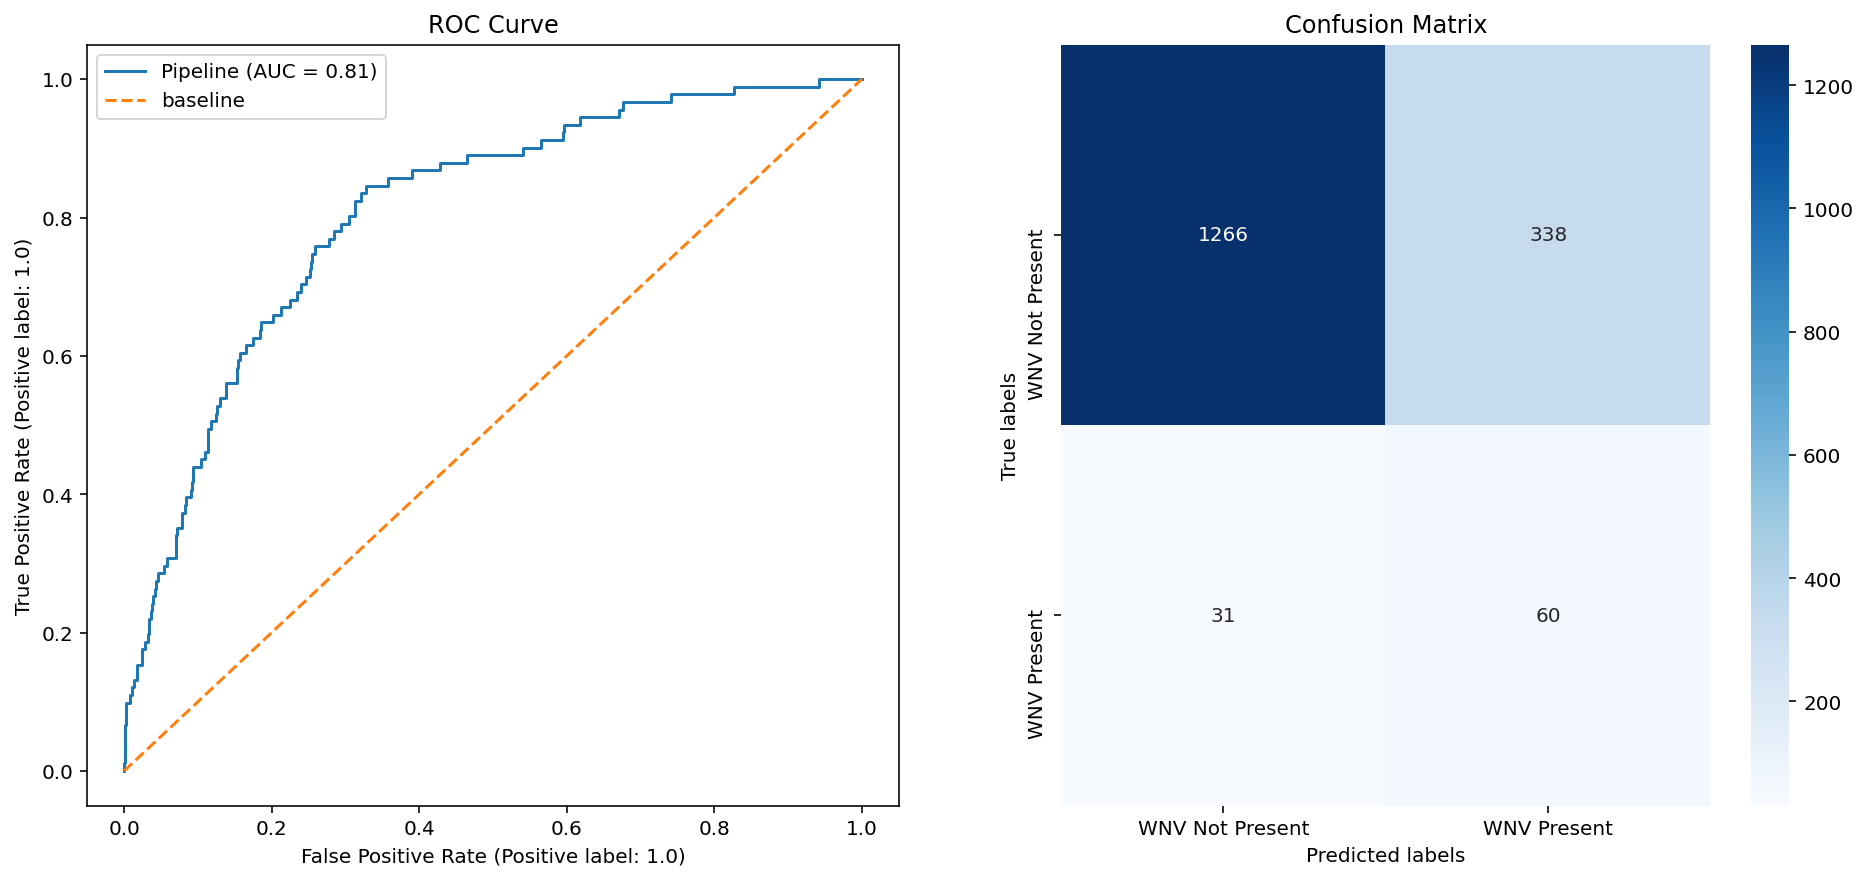

current_weather
Xtrain (6780, 424)
Xtest (1695, 424)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best parameters:  {'lr__C': 1.0}
Train Recall:  0.90583
Test Recall:  0.69231
Cross Val Recall: 0.39591


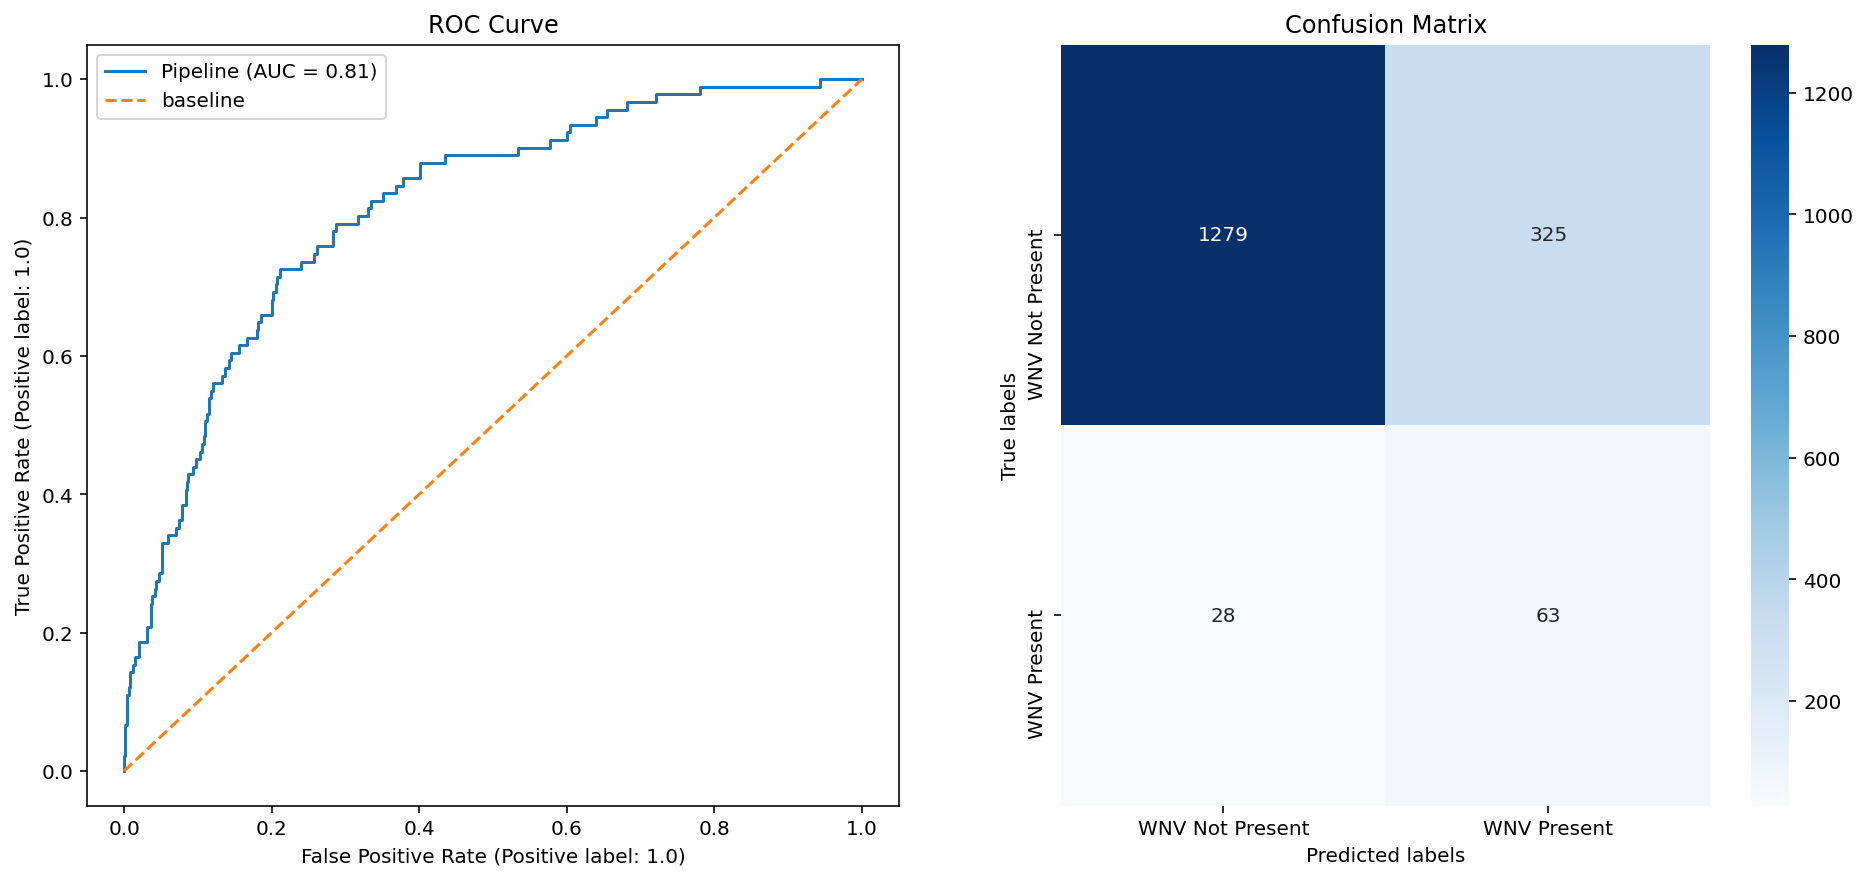

MA_shifted_weather
Xtrain (6780, 634)
Xtest (1695, 634)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best parameters:  {'lr__C': 0.1}
Train Recall:  0.92797
Test Recall:  0.69231
Cross Val Recall: 0.41813


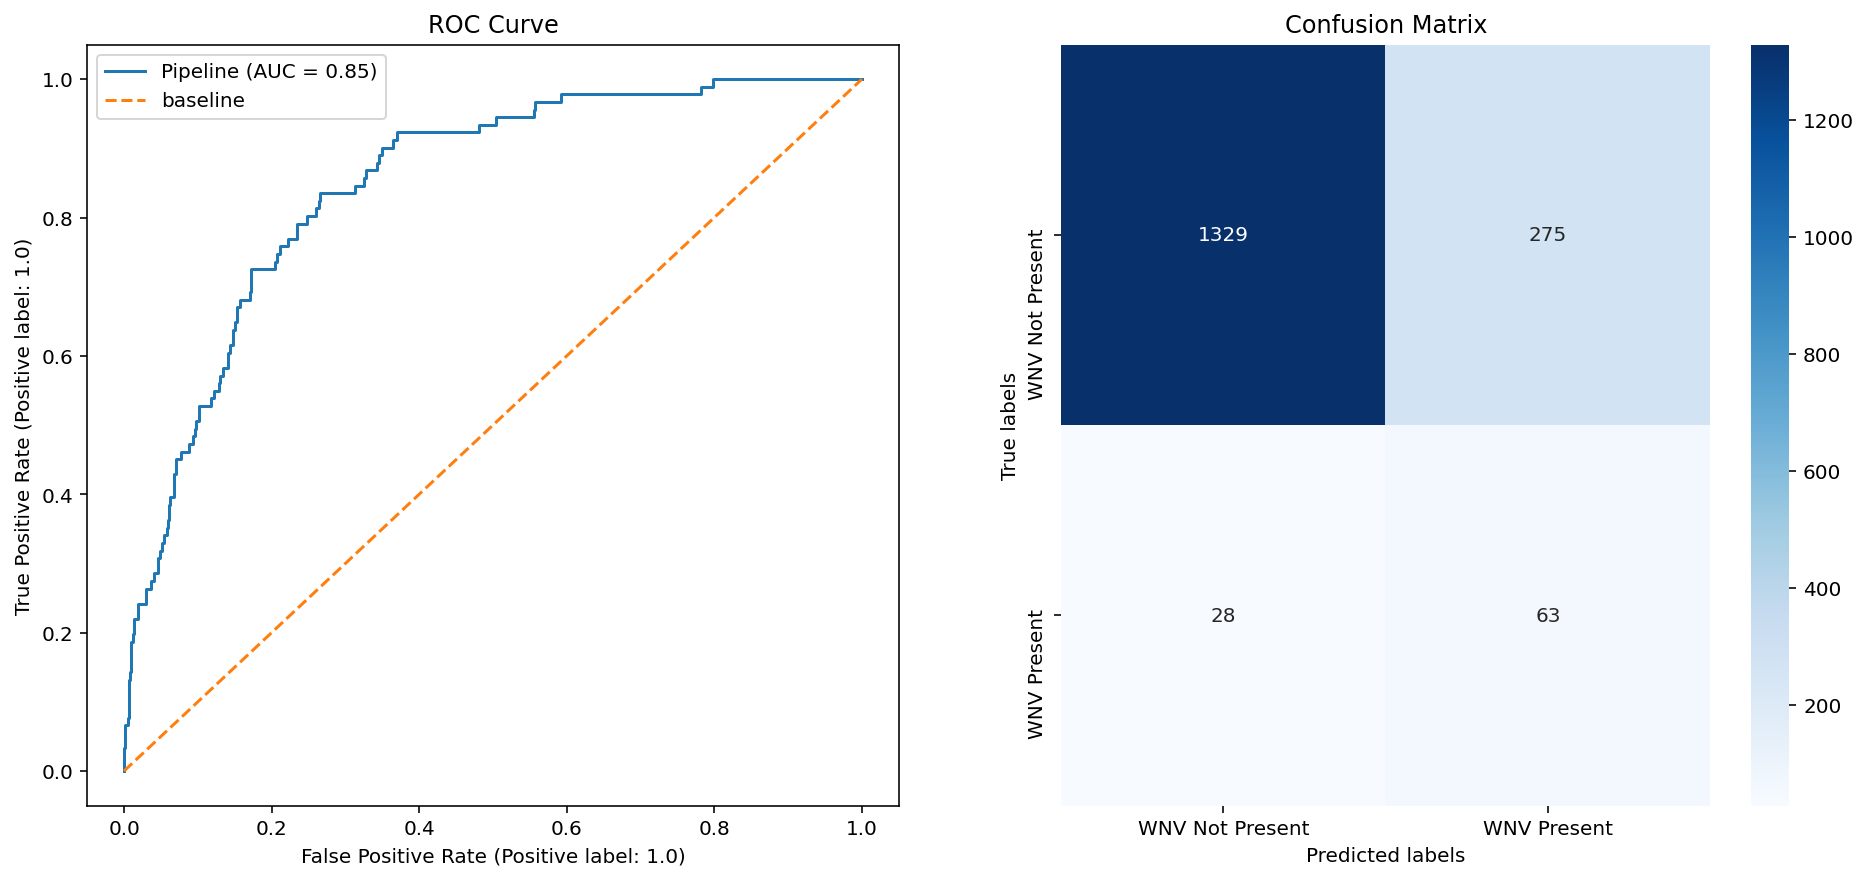

In [17]:
run_datasets('log reg', gs_lr)

In [18]:
def compare_models():
    return pd.DataFrame.from_dict(model_dictionary, 
                                  orient = 'index', 
                                  columns=['Recall', 'ROC AUC', 'True Positives', 'False Positives','True Negatives','False Negatives'])

In [19]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg baseline,0.65934,0.80794,60,338,1266,31
log reg current_weather,0.69231,0.81328,63,325,1279,28
log reg MA_shifted_weather,0.69231,0.84770,63,275,1329,28


### 3.3 KNN Classifier

In [20]:
# Pipeline
pipe_knn = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('knn', KNeighborsClassifier())
    ])

# Hyperparameters
knn_params = {
    'knn__n_neighbors': [3,5,15,20]
}

In [21]:
# Instantiate 5-fold GridSearchCV.
gs_knn = GridSearchCV(pipe_knn, param_grid = knn_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

baseline
Xtrain (6780, 405)
Xtest (1695, 405)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best parameters:  {'knn__n_neighbors': 15}
Train Recall:  0.9933
Test Recall:  0.68132
Cross Val Recall: 0.53918


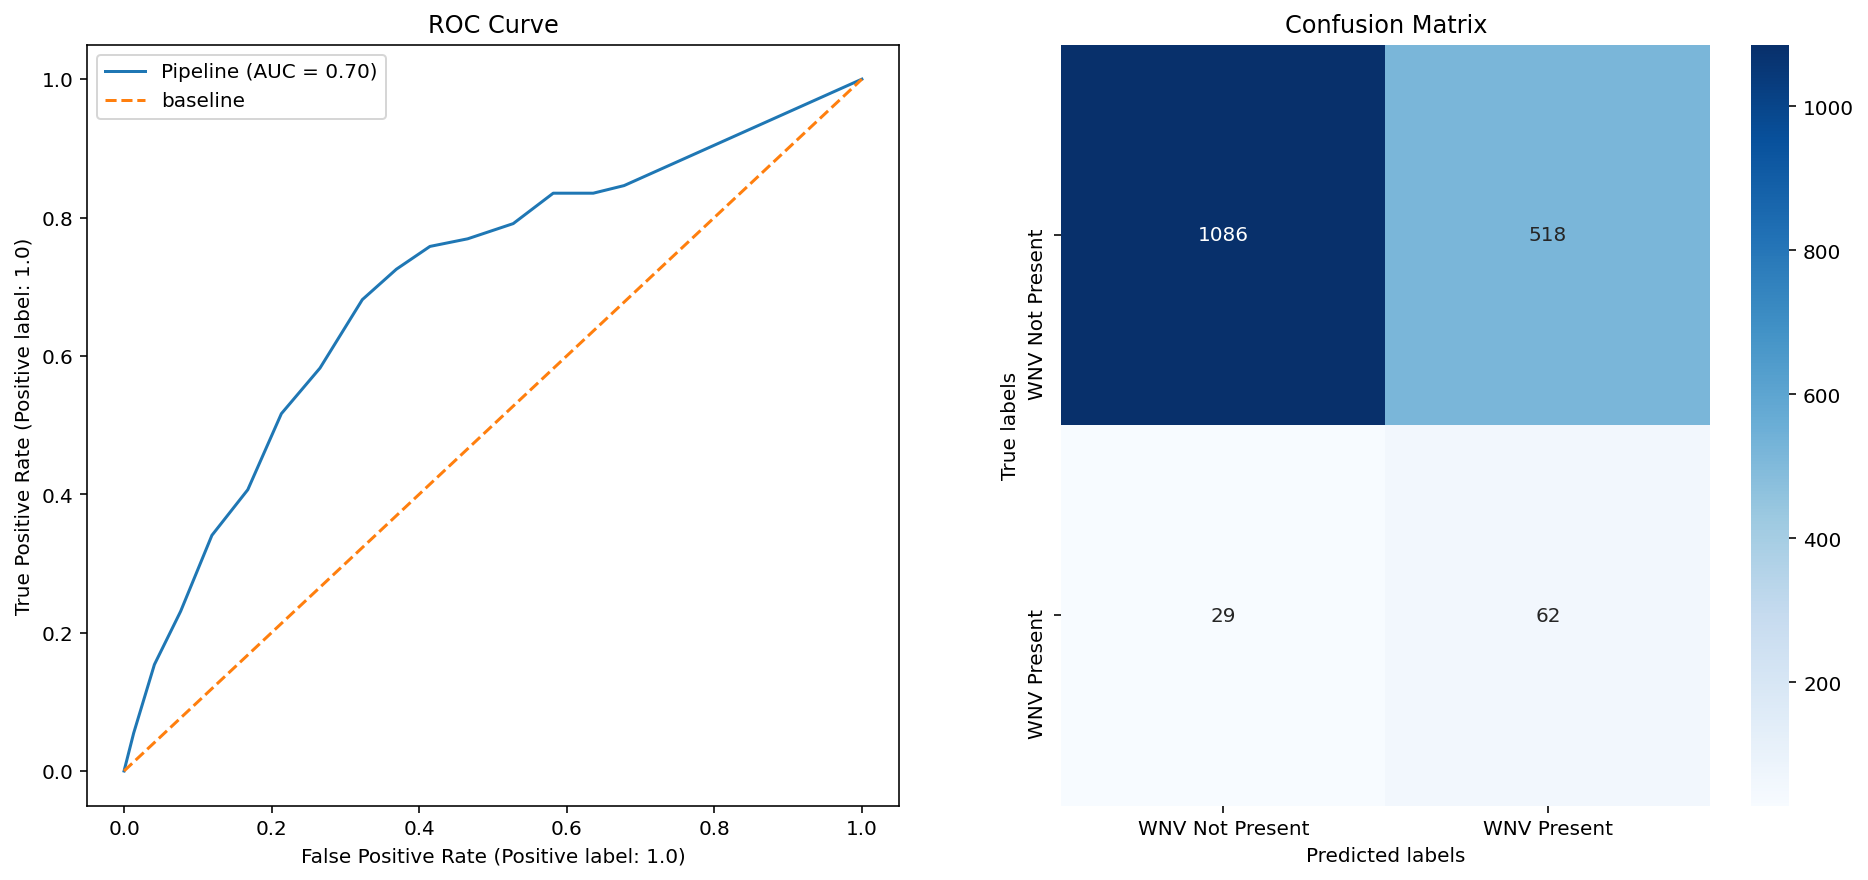

current_weather
Xtrain (6780, 424)
Xtest (1695, 424)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best parameters:  {'knn__n_neighbors': 15}
Train Recall:  0.99454
Test Recall:  0.69231
Cross Val Recall: 0.59474


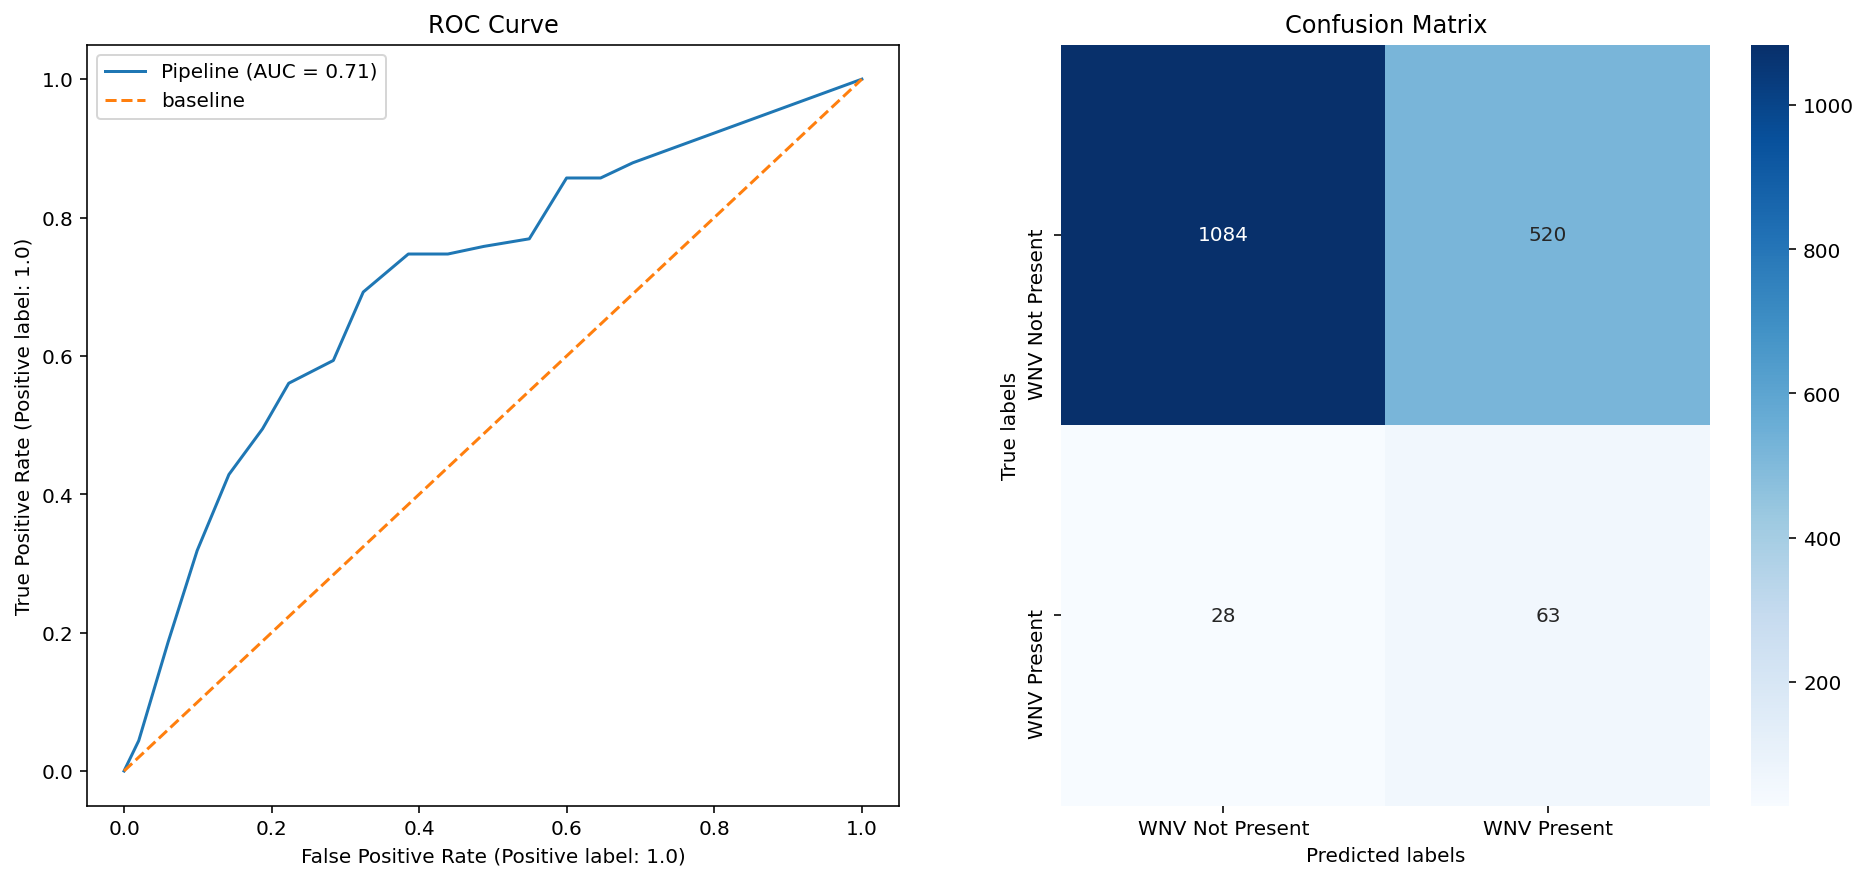

MA_shifted_weather
Xtrain (6780, 634)
Xtest (1695, 634)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best parameters:  {'knn__n_neighbors': 20}
Train Recall:  0.99782
Test Recall:  0.73626
Cross Val Recall: 0.79181


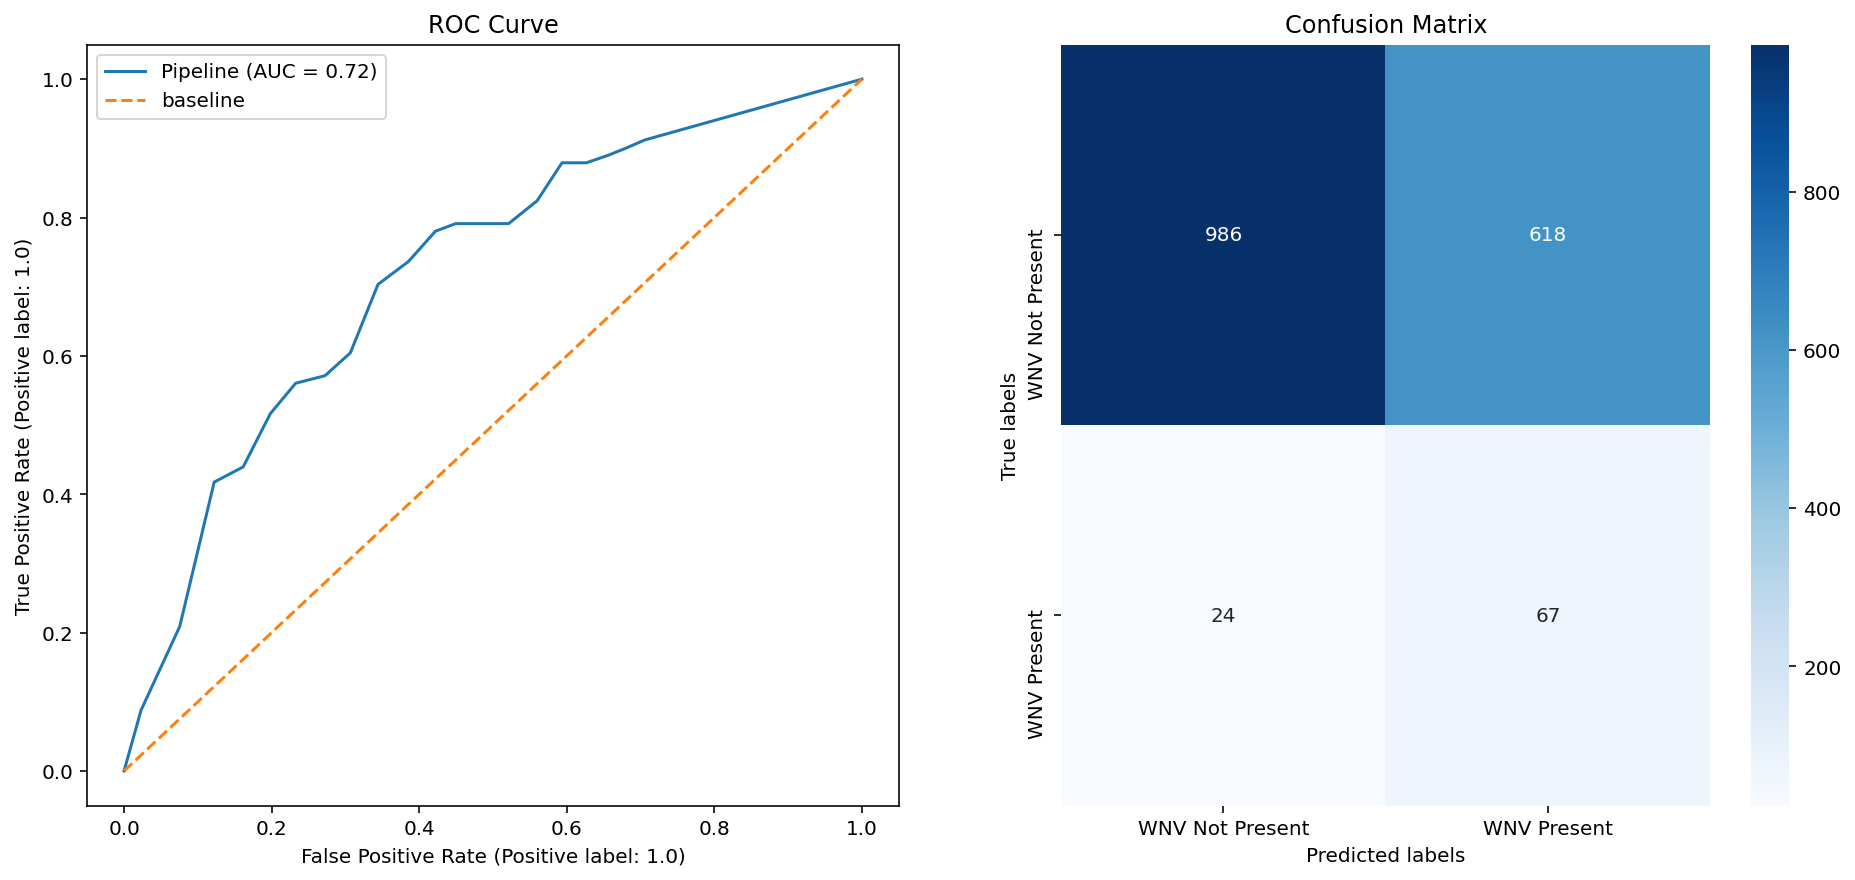

In [22]:
run_datasets('knn', gs_knn)

In [23]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg baseline,0.65934,0.80794,60,338,1266,31
log reg current_weather,0.69231,0.81328,63,325,1279,28
log reg MA_shifted_weather,0.69231,0.84770,63,275,1329,28
knn baseline,0.68132,0.70188,62,518,1086,29
knn current_weather,0.69231,0.70972,63,520,1084,28
knn MA_shifted_weather,0.73626,0.72040,67,618,986,24


### 3.4 Random Forest Classifier

In [24]:
# Pipeline
pipe_rf = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state = 42))
    ])

# Hyperparameters
rf_params = {
    'rf__n_estimators':[330,340,350],
    'rf__max_features':['auto', 'sqrt'],
    'rf__min_samples_leaf':[10,11,12],
    'rf__max_depth':[6,7,8]
}

In [25]:
# Instantiate 5-fold GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
                     verbose=1)

baseline
Xtrain (6780, 405)
Xtest (1695, 405)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
best parameters:  {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 350}
Train Recall:  0.94917
Test Recall:  0.62637
Cross Val Recall: 0.30643


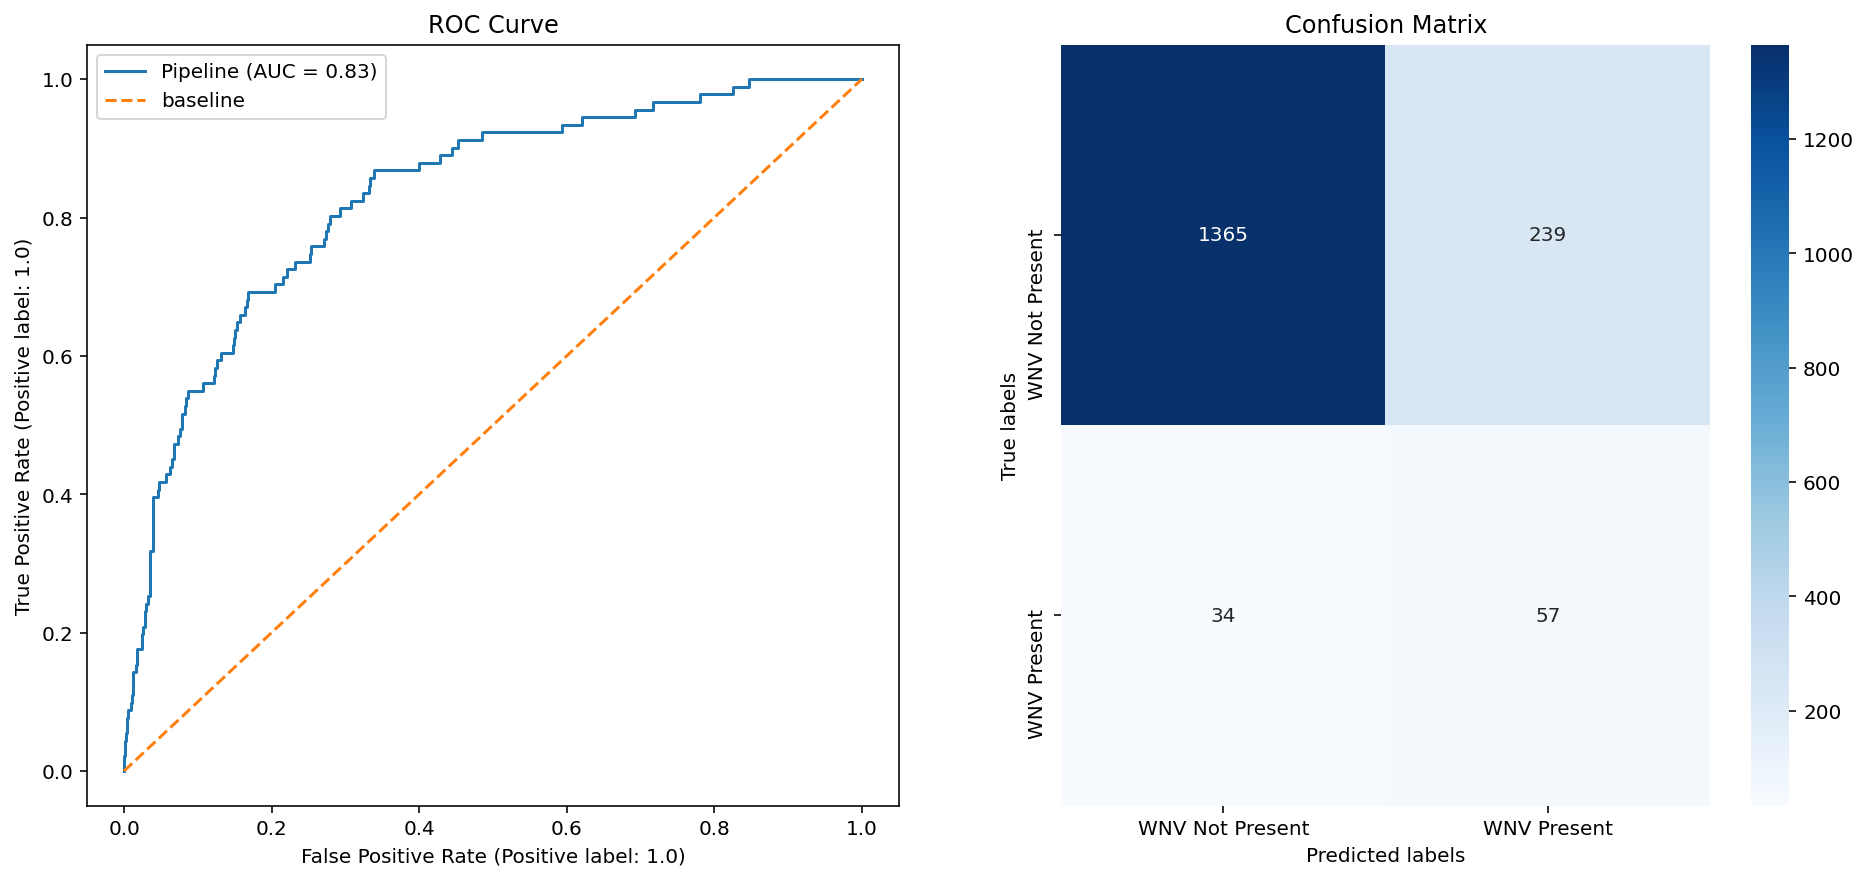

current_weather
Xtrain (6780, 424)
Xtest (1695, 424)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
best parameters:  {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 12, 'rf__n_estimators': 350}
Train Recall:  0.95541
Test Recall:  0.57143
Cross Val Recall: 0.3614


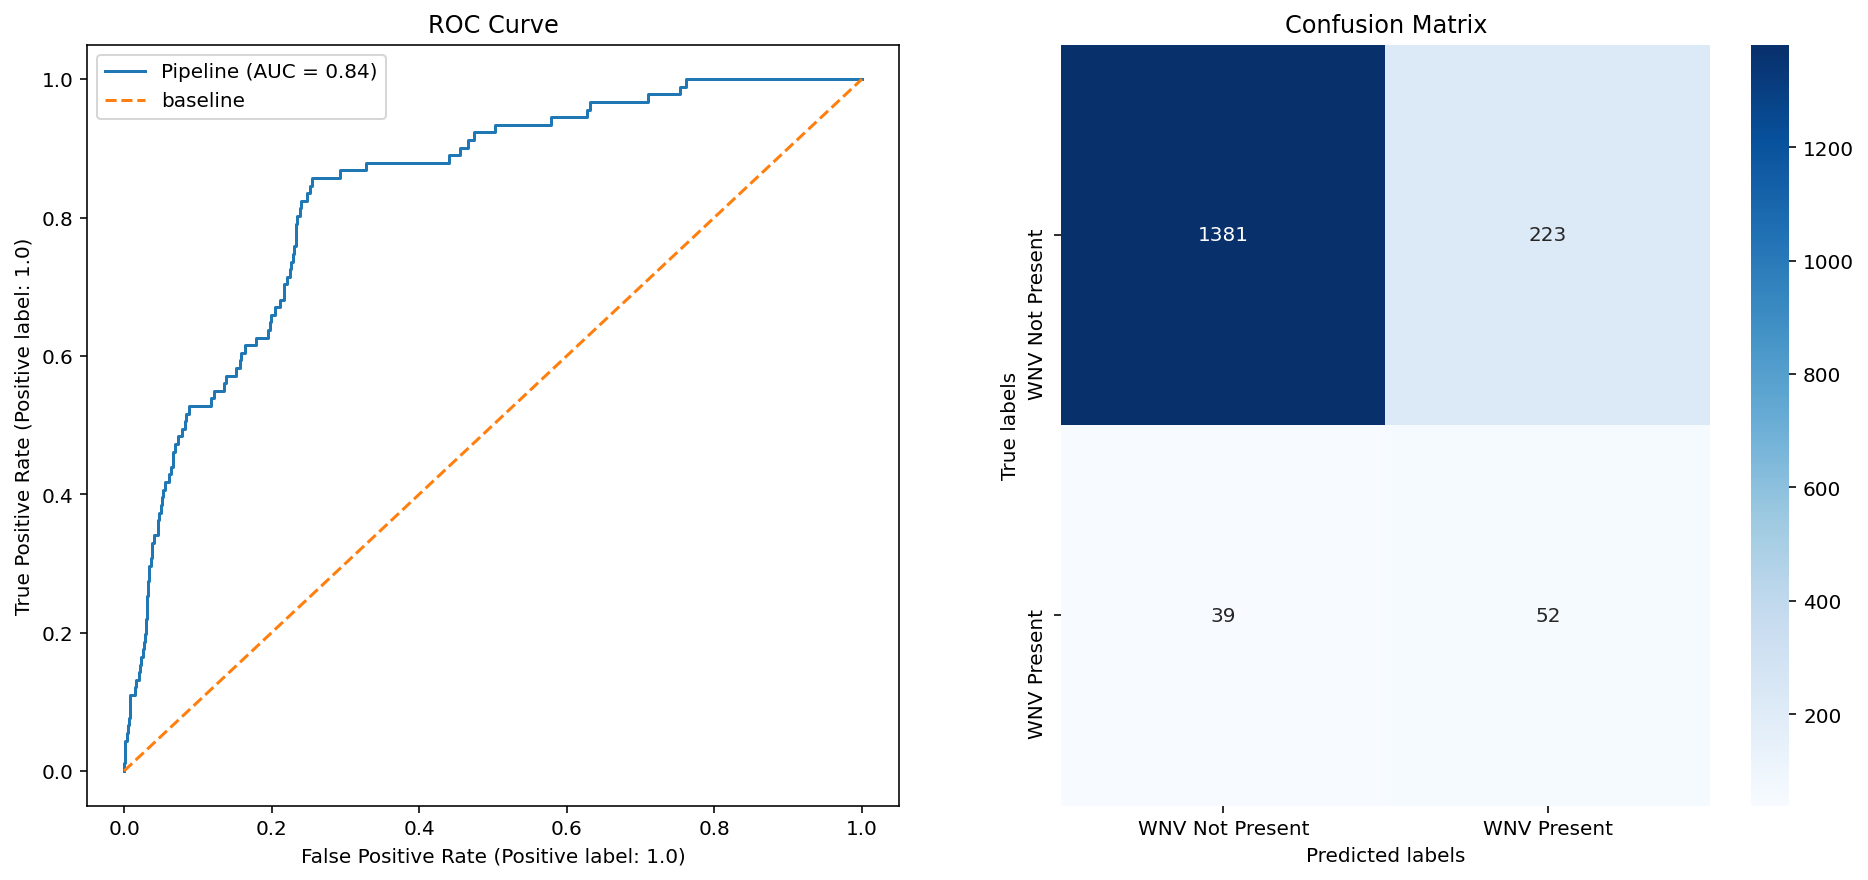

MA_shifted_weather
Xtrain (6780, 634)
Xtest (1695, 634)
Fitting 5 folds for each of 54 candidates, totalling 270 fits
best parameters:  {'rf__max_depth': 7, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 340}
Train Recall:  0.9643
Test Recall:  0.75824
Cross Val Recall: 0.4269


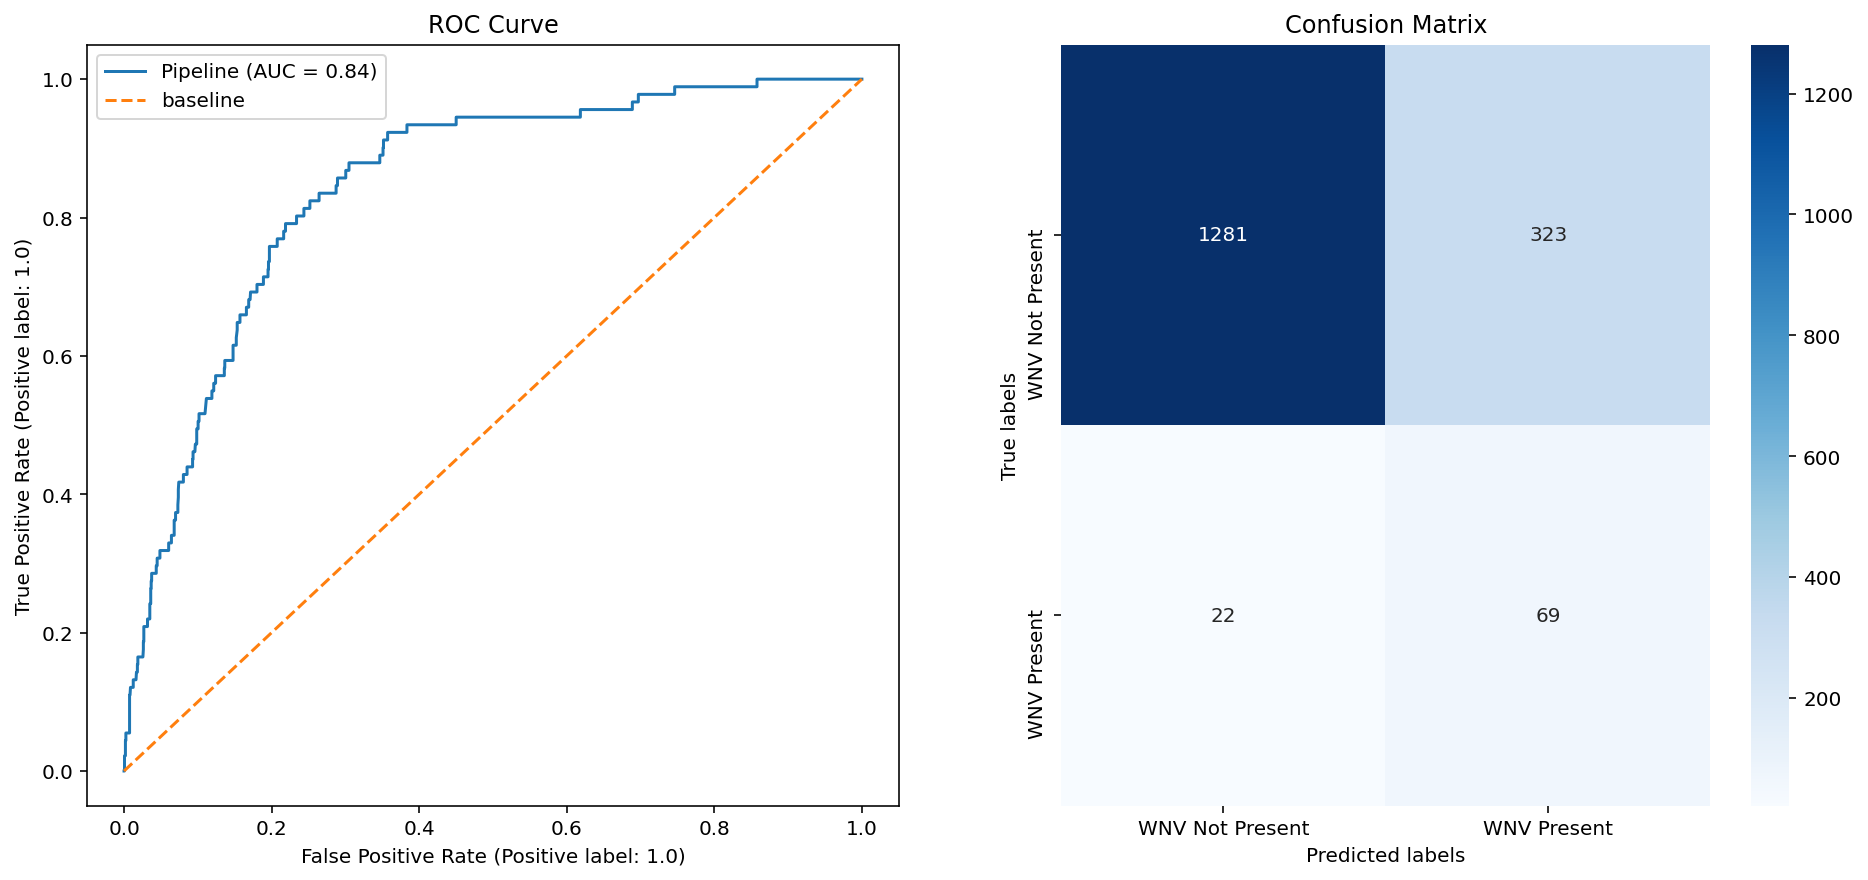

In [26]:
run_datasets('rf', gs_rf)

In [27]:
compare_models()

,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
log reg baseline,0.65934,0.80794,60,338,1266,31
log reg current_weather,0.69231,0.81328,63,325,1279,28
log reg MA_shifted_weather,0.69231,0.84770,63,275,1329,28
knn baseline,0.68132,0.70188,62,518,1086,29
knn current_weather,0.69231,0.70972,63,520,1084,28
knn MA_shifted_weather,0.73626,0.72040,67,618,986,24
rf baseline,0.62637,0.83144,57,239,1365,34
rf current_weather,0.57143,0.83710,52,223,1381,39
rf MA_shifted_weather,0.75824,0.84420,69,323,1281,22


<AxesSubplot:>

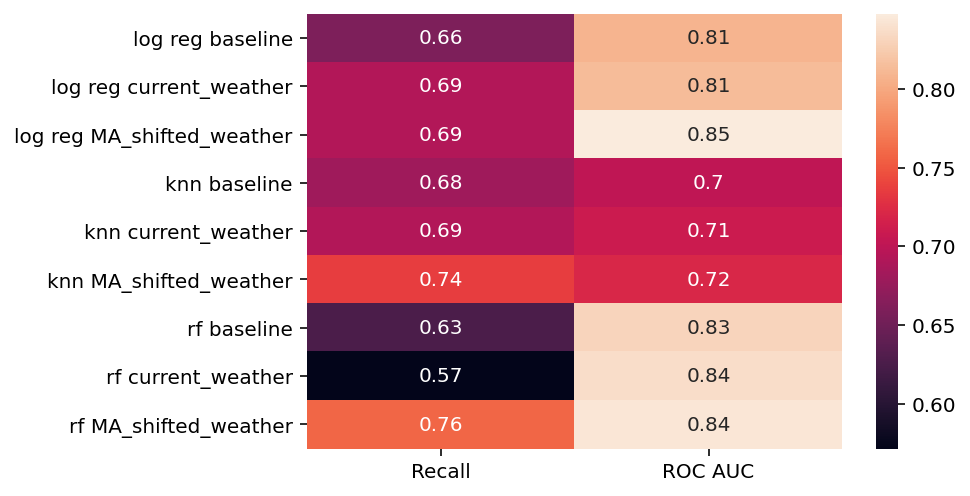

In [28]:
sns.heatmap(compare_models()[['Recall', 'ROC AUC']], annot = True)

- The Random Forest classifier and logistic regression models with the moving average and time lagged weather data have the best ROC AUC score on the test data
- The Random Forest classifier and KNN with moving average and time lagged weather data has the best recall score
- We will save these 3 models for further evaluation and submission to kaggle

## 4. Kaggle Submission

In [32]:
# train test split
test_wlag = pd.read_csv('../models/model_datasets/test_wlag.csv')
train_wlag = train_wlag.drop('date', axis = 1)
test_wlag = test_wlag.drop('date', axis =1)

Xtrain,Xtest,ytrain,ytest=train_test_split(train_wlag.drop('wnvpresent',1),
                                           train_wlag['wnvpresent'],test_size=0.2,
                                           random_state=42,
                                           stratify=train_wlag['wnvpresent'])

In [33]:
#scale
ss = StandardScaler()
Xs_train = ss.fit_transform(Xtrain)
Xs_test = ss.transform(Xtest)
        
#smote
smt=SMOTE(random_state=42)
Xsm_train,ysm_train=smt.fit_resample(Xs_train,ytrain)

### 4.1 Logistic Regression

In [34]:
# log reg model from best estimator in part 3

lr = LogisticRegression(solver='newton-cg', random_state = 42, C= 0.1)
lr.fit(Xs_train, ytrain)
pickle.dump(lr, open('../models/logreg.pkl','wb'))

In [35]:
lr_pred = lr.predict_proba(test_wlag)
lr_pred = pd.DataFrame(lr_pred)
lr_pred['Id'] = [i for i in range(1,116294)]
lr_pred.rename({1:'WnvPresent'}, axis=1, inplace=True)
lr_pred.drop([0],axis=1,inplace=True)
lr_pred.to_csv('../models/kaggle/lr_pred.csv',index=False)

Logistic Regression Kaggle score: 0.5

### 4.2 KNN Classifier

In [36]:
# knn model from best estimator in part 3

knn = KNeighborsClassifier(n_neighbors= 20)
knn.fit(Xs_train, ytrain)
pickle.dump(knn, open('../models/knn.pkl','wb'))

In [37]:
knn_pred = knn.predict_proba(test_wlag)
knn_pred = pd.DataFrame(knn_pred)
knn_pred['Id'] = [i for i in range(1,116294)]
knn_pred.rename({1:'WnvPresent'}, axis=1, inplace=True)
knn_pred.drop([0],axis=1,inplace=True)
knn_pred.to_csv('../models/kaggle/knn_pred.csv',index=False)

KNN Classifier Kaggle score: 0.41520

### 4.3 Random Forest Classifier

In [38]:
# rf model from best estimator in part 3

rf = RandomForestClassifier(max_depth= 7, 
                            max_features = 'auto', 
                            min_samples_leaf = 10, 
                            n_estimators = 330,
                            random_state = 42)
rf.fit(Xs_train, ytrain)
pickle.dump(rf, open('../models/rf.pkl','wb'))

In [39]:
rf_pred = rf.predict_proba(test_wlag)
rf_pred = pd.DataFrame(rf_pred)
rf_pred['Id'] = [i for i in range(1,116294)]
rf_pred.rename({1:'WnvPresent'}, axis=1, inplace=True)
rf_pred.drop([0],axis=1,inplace=True)
rf_pred.to_csv('../models/kaggle/rf_pred.csv',index=False)

Random Forest Kaggle score: 0.69134

## 5. Feature Interpretation

### 5.1 Logistic Regression

In [40]:
#create dataframe of coefficients
feature_names = train_wlag.columns[train_wlag.columns != 'wnvpresent'].values
coef = pd.DataFrame(feature_names, lr.coef_.tolist(),columns=['Feature']) 
coef.reset_index(inplace=True)

coef.rename({'level_0':'Coefficient'}, axis=1, inplace=True)

#sort coefficients by magnitude 
coef['abs'] = coef['Coefficient'].abs()
coef25 = coef.sort_values(by='abs',ascending=False)[:25]
coef25[:5]

,Coefficient,Feature,abs
3,0.428959,year,0.428959
13,-0.402559,species_CULEX TERRITANS,0.402559
585,0.374941,resultdir_shift_7,0.374941
6,-0.333218,days_since_max_wnv,0.333218
548,-0.325797,rel_humidity_shift_1,0.325797


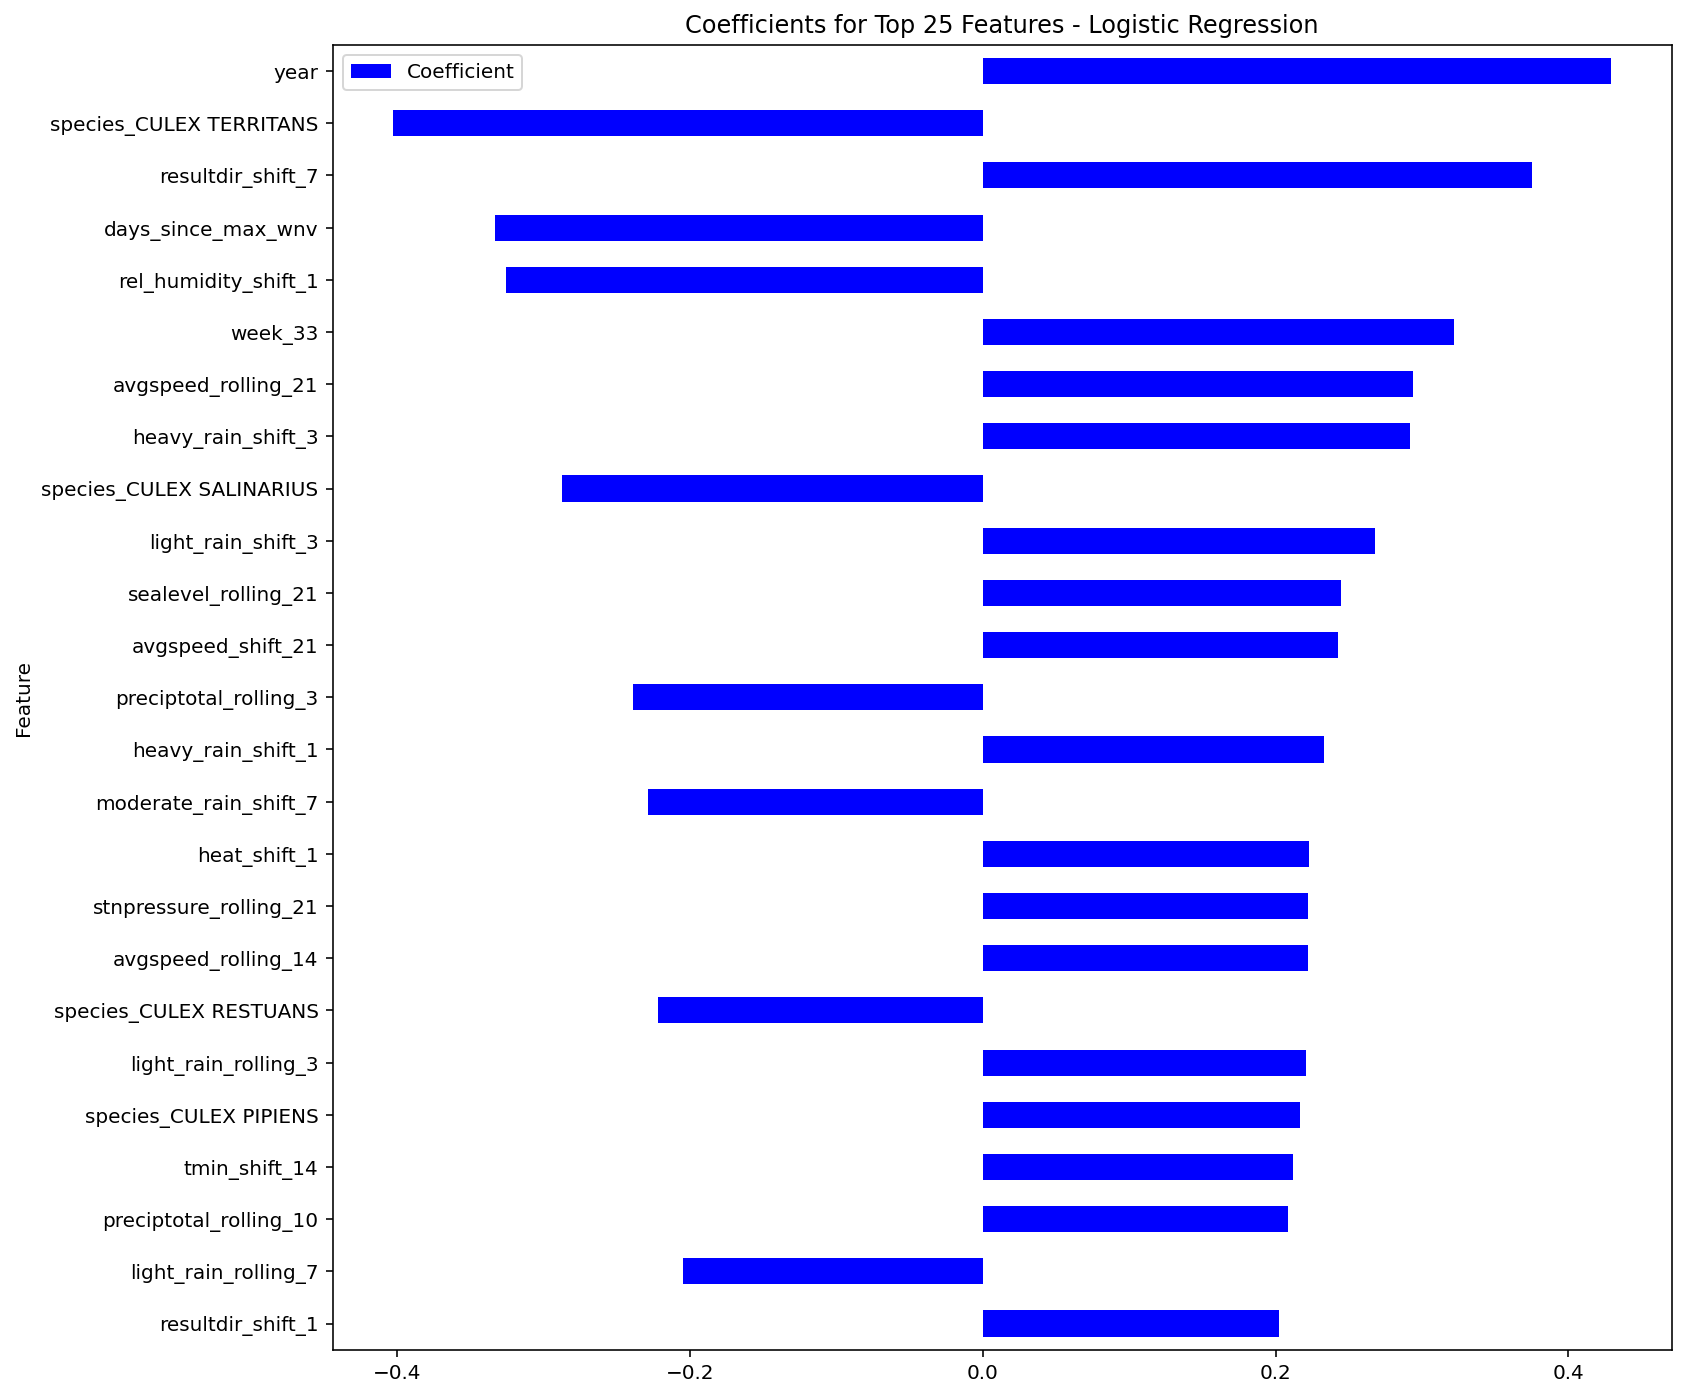

In [44]:
#create plot of coefficients
coef25.sort_values(by='abs').plot(y='Coefficient',x='Feature',kind='barh', figsize=(12,12), color='b', 
                                  title='Coefficients for Top 25 Features - Logistic Regression');

- species Culex Territans, followed by Culex Salinarius and Culex Restuans seem to have the highest negative correlation with the presence of WNV (i.e. when these species are present compared to other species, it is less likely WNV is present in the area). 
- The year and time of the year are important features -> if it is the 33rd week of the year (which is in August), it is more likely WNV is present
- More than current day weather data, the rolling averages and time lagged weather data do have an impact on the presence of WNV: mainly the relative humidity of the day before, the wind direction of a week before, and heavy rain or light rain from 3 days before are important features in this model.

### 5.2 Random Forest Classifier

In [42]:
#create dataframe of coefficients
feat = pd.DataFrame(feature_names, rf.feature_importances_.tolist(),columns=['Feature']) 
feat.reset_index(inplace=True)

feat.rename({'index':'weight'}, axis=1, inplace=True)

#sort coefficients by magnitude 
feat25 = feat.sort_values(by='weight',ascending=False)[:25]
feat25[:5]

,weight,Feature
1,0.031119,longitude
0,0.021845,latitude
5,0.021053,day_of_year
6,0.016099,days_since_max_wnv
513,0.014502,wetbulb_rolling_21


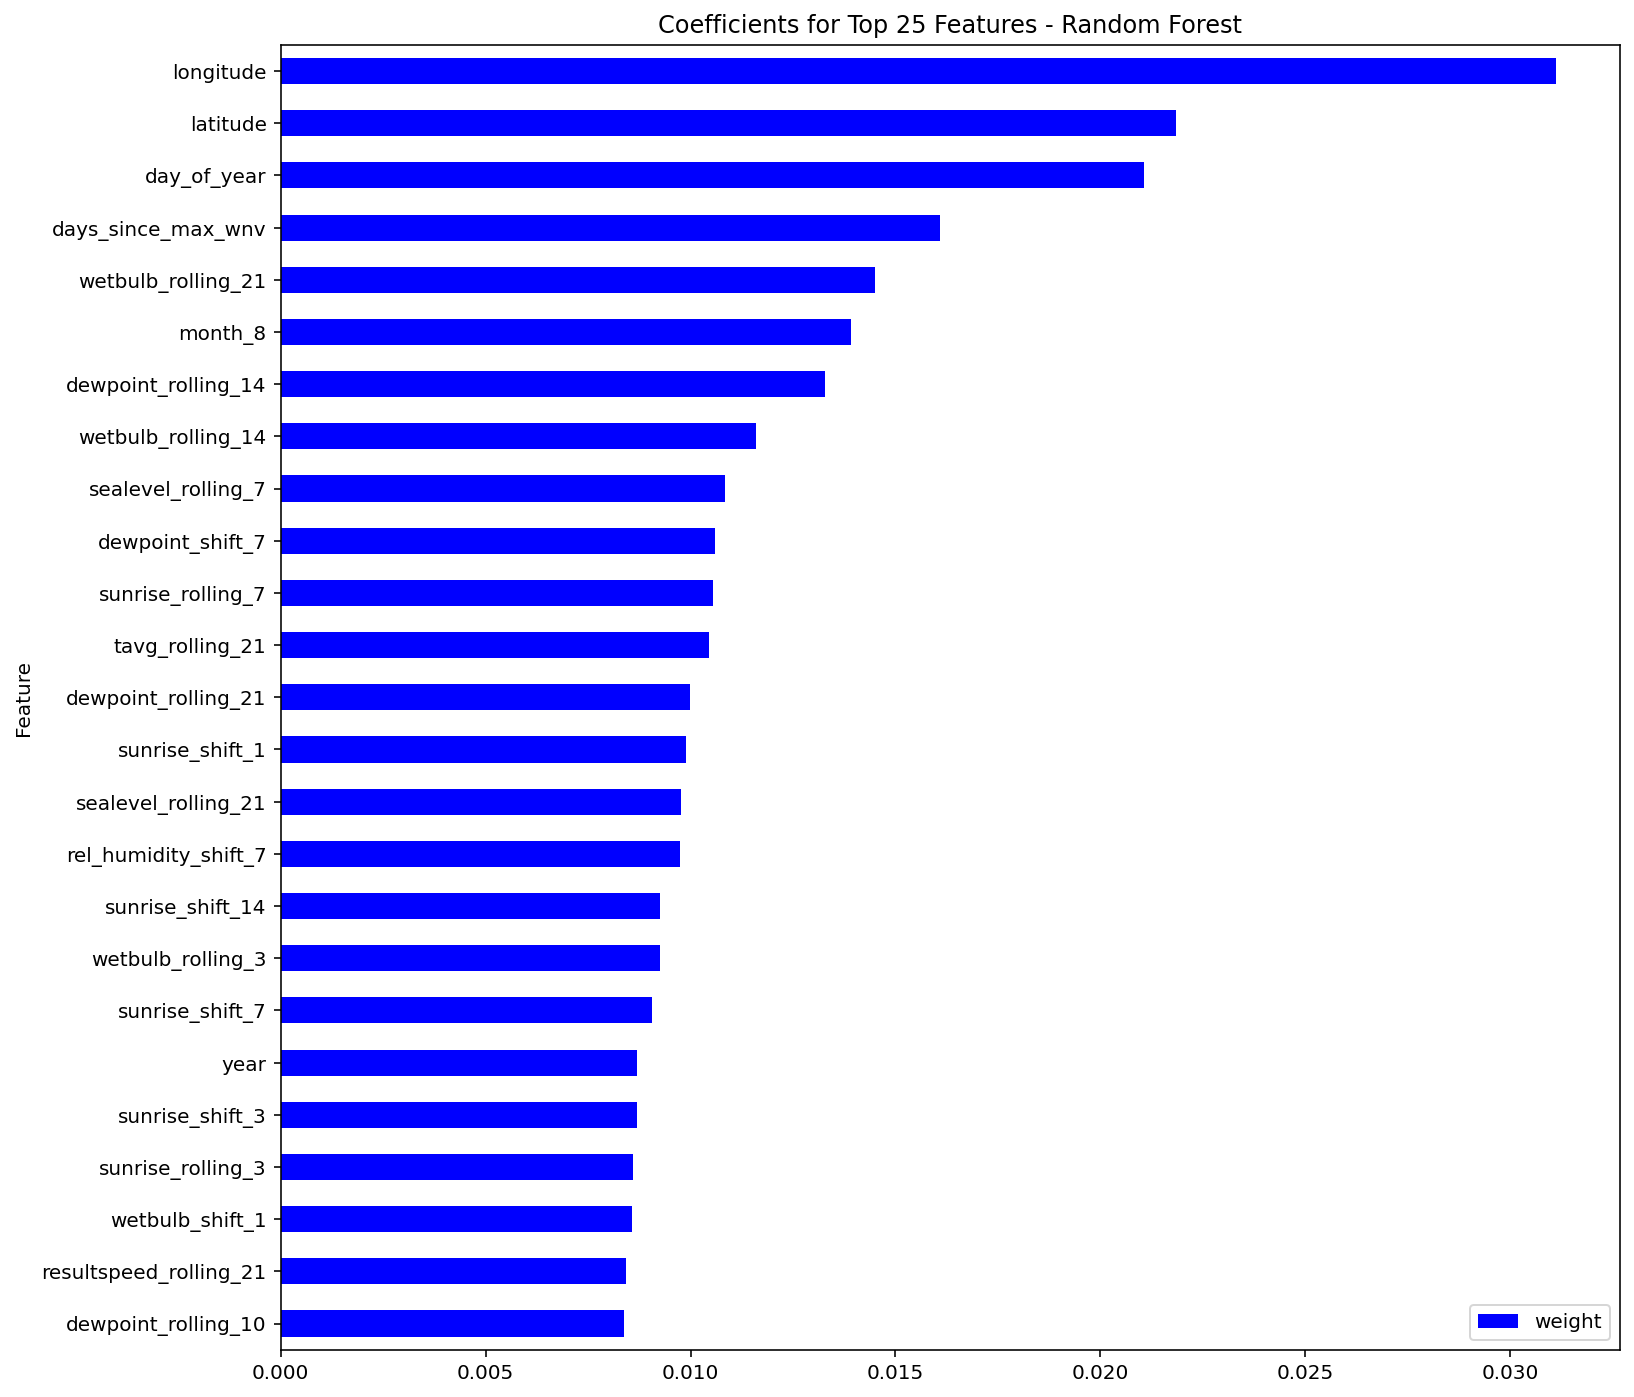

In [45]:
#create plot of coefficients
feat25.sort_values(by='weight').plot(y='weight',x='Feature',kind='barh', figsize=(12,12), color='b', 
                                  title='Coefficients for Top 25 Features - Random Forest');

- Interestingly, the longitude and latitude have a higher importance to the random forest model than the logistic regression model. 
- There is a similar importance ot the month of August (which appears as month_8 in the features for this model), and the days since max wnv (which is the number of days since August 15, when there were a maximum number of WNV cases present) are important features
- The dewpoint and wetbulb are important features for this model as the rolling averages and time lagged data for these features appear several times in the top 25 features.